In [ ]:
import numpy as np
from matplotlib import pylab
import pybullet as p
import pybullet_data
import time

def get_image(pybullet, camTargetPos=[0,0,0], camDistance=1, ypr=[0, 0, 0], image_size=(640, 480), fig_size=(10, 5)):
    pylab.figure(figsize=fig_size)
    yaw, pitch, roll = ypr
    upAxisIndex = 2
    pixelWidth, pixelHeight = image_size
    nearPlane = 0.01
    farPlane = 100
    fov = 60
    viewMatrix = pybullet.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch, roll, upAxisIndex)
    aspect = pixelWidth / pixelHeight
    projectionMatrix = pybullet.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)
    img_arr = pybullet.getCameraImage(pixelWidth, pixelHeight, viewMatrix, projectionMatrix)
    w = img_arr[0]  #width of the image, in pixels
    h = img_arr[1]  #height of the image, in pixels
    rgb = img_arr[2]  #color data RGB
    dep = img_arr[3]  #depth data
    # print("w=",w,"h=",h)
    np_img_arr = np.reshape(rgb, (h, w, 4))
    np_img_arr = np_img_arr * (1. / 255.)
    # remove grids
    pylab.axis('off')
    pylab.imshow(np_img_arr, interpolation='none', animated=True, label="pybullet")
    pylab.show()

def get_stl_obj(fileName, basePosition, baseOrientation, meshScale=1):
	col_shape_id = p.createCollisionShape(
		shapeType=p.GEOM_MESH,
		fileName=fileName,
		meshScale=[meshScale, meshScale, meshScale],
		flags=p.URDF_INITIALIZE_SAT_FEATURES #|p.GEOM_FORCE_CONCAVE_TRIMESH should only be used with fixed (mass=0) objects!
	)
	viz_shape_id = p.createVisualShape(
		shapeType=p.GEOM_MESH,
		fileName=fileName,
		meshScale=[meshScale, meshScale, meshScale],
	)
	body_id = p.createMultiBody(
		baseMass=1,
		baseCollisionShapeIndex=col_shape_id,
		baseVisualShapeIndex=viz_shape_id,
		basePosition=basePosition,
		baseOrientation=baseOrientation,
	)
	return body_id

def decompose_obj(fileName):
	output_mesh = "mug_vhacd.obj"   # File that will store the convex decomposition
	log_file = "vhacd_log.txt"      # Log file (for debugging)

	# Run VHACD to decompose the mug into convex parts.
	# Adjust the parameters as needed for precision and performance.
	p.vhacd(
		fileName,
		output_mesh,
		log_file,
		resolution=100000,          # Higher resolution for finer details
		depth=20,                   # Maximum number of decomposition levels
		concavity=0.0025,           # Lower concavity yields more convex parts
		planeDownsampling=4,
		convexhullDownsampling=4,
		alpha=0.04,
		beta=0.05,
		gamma=0.00125,
		minVolumePerCH=0.0001       # Minimum volume for each convex hull piece
	)

	print("VHACD decomposition complete. Check the file:", output_mesh)


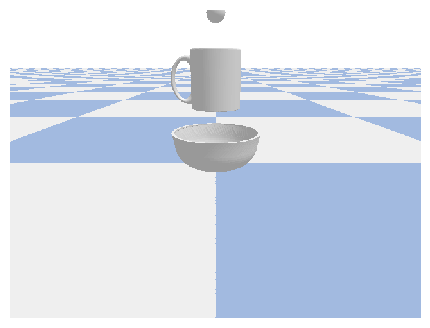

In [ ]:
try:
  p.disconnect()
except:
  pass

client = p.connect(p.GUI)
# client = p.connect(p.DIRECT)
dt = p.getPhysicsEngineParameters()['fixedTimeStep']
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetDebugVisualizerCamera(cameraDistance=1, cameraYaw=90, cameraPitch=-40, cameraTargetPosition=[0,0,0])

p.setGravity(0,0,-9.8)
p.loadURDF("plane.urdf")
ball = p.loadURDF("objects/sphere/sphere_small.urdf", [0, 0, 0.5], useFixedBase=False, globalScaling=1)
mug = p.loadURDF("objects/mug.urdf", [0, 0, 0.3], [1, 0, 0, 1], useFixedBase=False, globalScaling=0.02)
bowl = p.loadURDF("objects/bowl.urdf", [0, 0, 0], [0, 0, 0, 1], useFixedBase=False, globalScaling=1.5)
# apple = p.loadURDF("objects/apple.urdf", [0, 0, 0], [0, 0, 0, 1], useFixedBase=False, globalScaling=2)
# banana = p.loadURDF("objects/banana.urdf", [0, 0, 0], useFixedBase=False, globalScaling=2)

get_image(p, [0, 0, 0], 1, [180, -20, 0], fig_size=(8, 4))

if p.getConnectionInfo(client)['connectionMethod'] == p.GUI:
	while p.isConnected():
		p.stepSimulation()
		time.sleep(dt)
try:
	p.disconnect()
except:
	pass